In [1]:
#two body problem example

using Pkg
Pkg.activate(".")
using LinearAlgebra
using ForwardDiff
using Plots 
using TSSOS 
using DynamicPolynomials
using DifferentialEquations  

  Activating project at `~/Research/polynomial_opt`


In [2]:
#gravitational parameter for the Earth 
μ = 3.986004418e5 #km3/s2

398600.4418

In [3]:
#iss initial conditions
r0 = [6791.0; 0; 0] #km
v0 = [0; cosd(51.5)*7.66; sind(51.5)*7.66] #km/s
x_initial = [r0; v0]

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [4]:
#one iss period is around 90-93 minutes
#revs = 5

#working for 1/4 rev...
#suboptimality gap of 21% 
revs = 1

#finding the period
r_initial = norm(r0)

#finding the period for 1 rev
iss_period = 2*pi*sqrt(r_initial^3/μ)

period = revs*iss_period 

5569.440597283014

In [5]:
#amount of knot points per orbit 
knot_pts = 20

20

In [6]:
#total number of knot points
N=knot_pts*revs

#when revs is less than 1
#N = knot_pts

20

In [7]:
#define a timestep
h = period/(N-1) 

293.1284524885797

In [8]:
function two_body_dynamics(x)

    q = x[1:3]
    v = x[4:6]

    a = zeros(eltype(x), size(x))

    r = norm(q)
    
    a[1:3] = v

    a[4:6] = (-μ/r^3)*q

    return a

end

two_body_dynamics (generic function with 1 method)

In [9]:
function rk4_integrator(x)


    f1 = two_body_dynamics(x)
    f2 = two_body_dynamics(x+0.5*h*f1)
    f3 = two_body_dynamics(x+0.5*h*f2)
    f4 = two_body_dynamics(x+h*f3)

    xnext = x + (h/6.0)*(f1+2*f2+2*f3+f4)

    return xnext 

end

rk4_integrator (generic function with 1 method)

In [10]:
#integrate with symplectic euler to see what happens 

In [11]:
#semi implicit euler 

#input is state at timestep k 
#x = [qk, vk]

function symplectic_euler(x)

    #the q and the v are already scaled 

    #qk
    q = x[1:3]

    #vk
    v = x[4:6]

    #next timestep
    xnext = zeros(6)

    ak = (-μ/(norm(q)^3))*q

    #explicit euler on the velocities
    #vk1
    xnext[4:6] = v + h*ak

    #implicit euler on the positions
    #qk1
    xnext[1:3] = q + h*xnext[4:6]

    #xnext = [xk1, vk1] (state at timestep k+1)
    return xnext 

end

symplectic_euler (generic function with 1 method)

In [12]:
#integrate the orbit with symplectic euler to see if the orbit closes

xtraj = zeros(6, N)

xtraj[:,1] = x_initial

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [13]:
for i=1:N-1

    xtraj[:,i+1] = symplectic_euler(xtraj[:,i])

end

In [14]:
xtraj 

6×20 Matrix{Float64}:
 6791.0      6048.35     4534.31     2363.45     …   5438.53      6372.77
    0.0      1397.77     2617.28     3457.65        -3207.66     -2013.3
    0.0      1757.24     3290.37     4346.87        -4032.58     -2531.07
    0.0        -2.53354    -5.16511    -7.40583         4.69827      3.18713
    4.76846     4.76846     4.16031     2.86693         3.18325      4.07452
    5.99478     5.99478     5.23022     3.60422  …      4.00189      5.12237

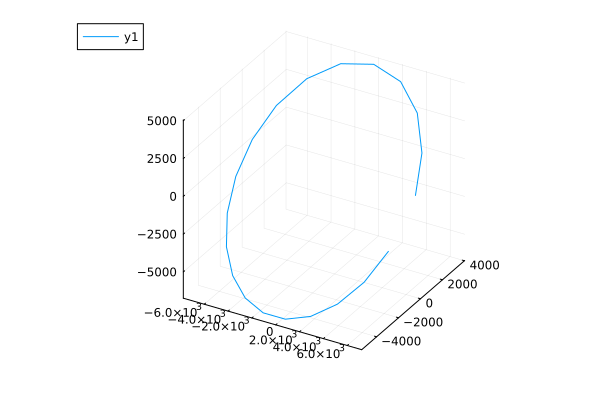

In [15]:
plot(xtraj[1,:], xtraj[2,:], xtraj[3,:])

In [16]:
#not completely periodic. off in the y and the z be 10's of km

In [17]:
#integrate with rk4 to see how much better it is compared to symplectic euler
x_traj_rk4 = zeros(6, N)

6×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [18]:
x_traj_rk4[:,1] = x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [19]:
for i = 1:N-1

    x_traj_rk4[:,i+1] = rk4_integrator(x_traj_rk4[:,i])

end

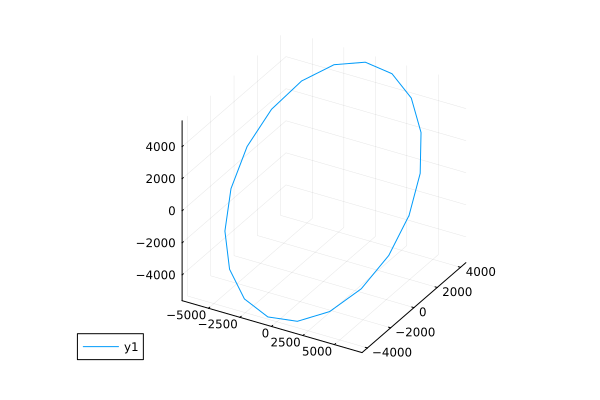

In [20]:
plot(x_traj_rk4[1,:], x_traj_rk4[2,:], x_traj_rk4[3,:])

In [21]:
#difference between the symplectic euler and rk4 final positions after 5 rev sim
x_traj_rk4[:,end] - xtraj[:,end] 

6-element Vector{Float64}:
  413.16922402257933
 2047.5158083143765
 2574.080155811487
   -3.2492170468234614
    0.6954931346045203
    0.8743547029131173

In [22]:
function two_body_dynamics_form!(du, u, p, t)

    du[1:6] = two_body_dynamics(u[1:6])

end

two_body_dynamics_form! (generic function with 1 method)

In [23]:
#rk78 integrator using DifferentialEquations.jl
function two_body_dynamics_integrate(x_0, period)

    tspan = (0.0, period)
    prob = ODEProblem(two_body_dynamics_form!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)


    return sol 
end

two_body_dynamics_integrate (generic function with 1 method)

In [24]:
function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [25]:
#use rk78 to integrate the initial condition to 5 revs and check the trajectory 
final_state_sol = two_body_dynamics_integrate(x_initial, period)

retcode: Success
Interpolation: 3rd order Hermite
t: 98-element Vector{Float64}:
    0.0
    0.015420761572399714
    0.03973162174632696
    0.07504175761147455
    0.12639569705908932
    0.19896876272950367
    0.3224337491964102
    0.49042461239594526
    0.7195320692507651
    1.0463564696437295
    ⋮
 5016.91770413408
 5094.15147399914
 5171.441759611154
 5248.824968236176
 5326.348291684807
 5404.064250493651
 5482.087007261329
 5560.53833531248
 5569.440597283014
u: 98-element Vector{Vector{Float64}}:
 [6791.0, 0.0, 0.0, 0.0, 4.768462116644166, 5.994778481489491]
 [6790.999998972334, 0.07353331736408096, 0.09244404963773876, -0.00013328342280136, 4.768462115922566, 5.994778480582315]
 [6790.999993177981, 0.1894587330667543, 0.2381822709998041, -0.0003434049941977497, 4.768462111853924, 5.994778475467331]
 [6790.999975664162, 0.357833777909273, 0.44985871320505544, -0.0006485945748592281, 4.768462099556179, 5.9947784600069465]
 [6790.999930959346, 0.6027130910906073, 0.75771420

In [26]:
all_states = get_state(final_state_sol)

6×98 Matrix{Float64}:
 6791.0      6791.0          6791.0          …  6790.84       6790.97
    0.0         0.0735333       0.189459         -29.0193       13.4306
    0.0         0.092444        0.238182         -36.4822       16.8846
    0.0        -0.000133283    -0.000343405        0.0525991    -0.0243437
    4.76846     4.76846         4.76846            4.76835       4.76844
    5.99478     5.99478         5.99478      …     5.99464       5.99475

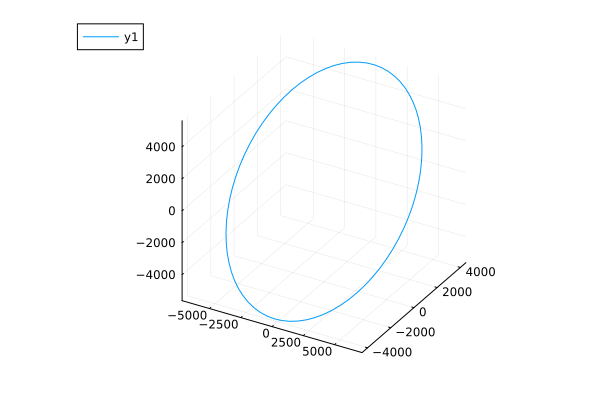

In [27]:
plot(all_states[1,:], all_states[2,:], all_states[3,:]) 

In [28]:
size(all_states)[2]

98

In [29]:
#find a good position and velocity scale 

position_normz = zeros(size(all_states)[2])

velocity_normz = zeros(size(all_states)[2])

for i=1:size(all_states)[2]

    position_normz[i] = norm(all_states[1:3, i])

    velocity_normz[i] = norm(all_states[4:6, i])

end

In [30]:
position_scale = maximum(position_normz) 

#try setting the timescale to scale the period to 1 
#works for the ipopt example 
time_scale = period  

#scale the maximum velocity to 1
#time_scale = position_scale/maximum(velocity_normz)

velocity_scale = position_scale/time_scale

acceleration_scale = position_scale/time_scale^2

μ_scaled = μ/(position_scale^3/time_scale^2)

h_scaled = h/time_scale

0.052631578947368425

In [31]:
time_scale 

5569.440597283014

In [32]:
position_scale 

6791.0

In [33]:
#difference between ground truth (rk78) and the two integrators (rk4 and semi implicit euler)

diff_semi_euler = all_states[:,end] - xtraj[:,end]

6-element Vector{Float64}:
  418.19858080438826
 2026.7333432648968
 2547.9530164480266
   -3.211478720182192
    0.6939193860056898
    0.872376229769201

In [34]:
diff_rk4 = all_states[:,end] - x_traj_rk4[:,end]

6-element Vector{Float64}:
   5.029356781808929
 -20.782465049479665
 -26.12713936346046
   0.037738326641269054
  -0.0015737485988305266
  -0.001978473143916304

In [35]:
#going to try the polynomial optimization 

@polyvar q[1:3, 1:N]
@polyvar v[1:3, 1:N]

@polyvar a[1:3, 1:N]

@polyvar r[1:N]

@polyvar u[1:3,1:N-1]

(PolyVar{true}[u₁₋₁ u₁₋₂ … u₁₋₁₈ u₁₋₁₉; u₂₋₁ u₂₋₂ … u₂₋₁₈ u₂₋₁₉; u₃₋₁ u₃₋₂ … u₃₋₁₈ u₃₋₁₉],)

In [36]:

Qq = Matrix(1.0*I, 3,3)

Qv = Matrix(1.0*I, 3,3)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [37]:
x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [38]:
#set in kiloNewtons (kN)

#this is what we want... but it doens't solve with large horizons, and small horizons solves with a suboptimality gap ~20%
#umax = 20e-9


#larger control authority makes the suboptimality gap smaller...
#currently 7%
umax = 20e-5

#in scaled units 
umax_bound = umax/acceleration_scale

0.9135228557403673

In [39]:
#found visually from the unconstrained control case
#this is in the scaled units 

#with the acceleration scale, this corresponds to a maximum of 0.4 N 
#this works 
#u_max_bound = 0.05



#testing 
#doesn't work. maybe not bounding the control space enough 
#u_max_bound = 1/acceleration_scale

In [40]:
#cost function 

f=0

#decreasae the semi major axis
for i=1:N

    f+= 1.0*r[i]

end


#add a cost on controls? (maybe), but it would avoid the bang-bang solution we want 
#introduce a cost or constraint or both

#for i=1:N-1

    #kinda works

    #    f += u[:,i]'*u[:,i]
#end


In [41]:
#initialize equality and inequality constraints 
eq = []
ineq = []

Any[]

In [42]:
x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [43]:
x_initial_scaled = [x_initial[1:3]/position_scale; x_initial[4:6]/velocity_scale]

6-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 3.9107151375414673
 4.916442739880163

In [44]:
#set the initial condition constraints
append!(eq, [q[1,1] - x_initial_scaled[1]])
append!(eq, [q[2,1] - x_initial_scaled[2]])
append!(eq, [q[3,1] - x_initial_scaled[3]])

append!(eq, [v[1,1] - x_initial_scaled[4]])
append!(eq, [v[2,1] - x_initial_scaled[5]])
append!(eq, [v[3,1] - x_initial_scaled[6]])

6-element Vector{Any}:
 q₁₋₁ - 1.0
 q₂₋₁
 q₃₋₁
 v₁₋₁
 v₂₋₁ - 3.9107151375414673
 v₃₋₁ - 4.916442739880163

In [45]:
#scaling all the units

In [46]:
#set the dynamics constraint between each timestep 

for i=1:N

    #acceleration constraint
    append!(eq, a[:,i]*r[i]^3 + μ_scaled*q[:,i])

    #slack r constraint 
    append!(eq, [r[i]^2 - q[:,i]'*q[:,i]])

end

In [47]:
#set a constraint on the r's
for i=1:N

    #lower bound on r that we want to reach 
    append!(ineq, [r[i]-0.75])

    #r is always positive (redundant constraint)
    append!(ineq, [r[i]])


end

In [48]:
#two types of control constraints. bound constraint 
# and norm constraint (socp constraint). 
#not sure if it can be handeled without squaring it and making it a polynomial 

#bound constraint 
for i=1:N-1

    #append!(ineq, norm(u_max_bound - u[1,i], 1))
    #maybe it can't handle the norm?
    #append!(ineq, norm(u[1,i] - u_max_bound, 1))


    #bound constraints
    #order 1 polynomial 
    #two inequalities to represent the absolute value 
    #g(x) >= 0
    append!(ineq, [umax_bound - u[1,i]])
    append!(ineq, [u[1,i] + umax_bound])

    append!(ineq, [umax_bound - u[2,i]])
    append!(ineq, [u[2,i] + umax_bound])

    append!(ineq, [umax_bound - u[3,i]])
    append!(ineq, [u[3,i] + umax_bound])


end

In [49]:
#check all the inequality constraints
ineq 

154-element Vector{Any}:
 r₁ - 0.75
 r₁
 r₂ - 0.75
 r₂
 r₃ - 0.75
 r₃
 r₄ - 0.75
 r₄
 r₅ - 0.75
 r₅
 ⋮
 u₂₋₁₈ + 0.9135228557403673
 -u₃₋₁₈ + 0.9135228557403673
 u₃₋₁₈ + 0.9135228557403673
 -u₁₋₁₉ + 0.9135228557403673
 u₁₋₁₉ + 0.9135228557403673
 -u₂₋₁₉ + 0.9135228557403673
 u₂₋₁₉ + 0.9135228557403673
 -u₃₋₁₉ + 0.9135228557403673
 u₃₋₁₉ + 0.9135228557403673

In [50]:
#add a control constraint. square the socp constraint to make it a polynomial

#leaving out for now..
# for i=1:N-1

#     append!(ineq, umax_scaled^2 - u[:,i]'*u[:,i])

# end

In [51]:
#check equality constraints
eq 

86-element Vector{Any}:
 q₁₋₁ - 1.0
 q₂₋₁
 q₃₋₁
 v₁₋₁
 v₂₋₁ - 3.9107151375414673
 v₃₋₁ - 4.916442739880163
 a₁₋₁r₁³ + 39.47841760435743q₁₋₁
 a₂₋₁r₁³ + 39.47841760435743q₂₋₁
 a₃₋₁r₁³ + 39.47841760435743q₃₋₁
 -q₁₋₁² - q₂₋₁² - q₃₋₁² + r₁²
 ⋮
 -q₁₋₁₈² - q₂₋₁₈² - q₃₋₁₈² + r₁₈²
 a₁₋₁₉r₁₉³ + 39.47841760435743q₁₋₁₉
 a₂₋₁₉r₁₉³ + 39.47841760435743q₂₋₁₉
 a₃₋₁₉r₁₉³ + 39.47841760435743q₃₋₁₉
 -q₁₋₁₉² - q₂₋₁₉² - q₃₋₁₉² + r₁₉²
 a₁₋₂₀r₂₀³ + 39.47841760435743q₁₋₂₀
 a₂₋₂₀r₂₀³ + 39.47841760435743q₂₋₂₀
 a₃₋₂₀r₂₀³ + 39.47841760435743q₃₋₂₀
 -q₁₋₂₀² - q₂₋₂₀² - q₃₋₂₀² + r₂₀²

In [52]:
#assuming mass is 1

In [53]:
for i=1:N-1

    #velocity dynamics constraint
    #added a control  
    append!(eq, v[:,i+1] - (v[:,i] + h_scaled*(a[:,i] + u[:,i])))

    #position dynamics constraint 
    append!(eq, q[:,i+1] - (q[:,i] + h_scaled*v[:,i+1]))

end

In [54]:
#add the inequality constraint
pop = append!([f], ineq)

#add the equality constraint
pop = append!(pop, eq)

355-element Vector{Polynomial{true, Float64}}:
 r₁ + r₂ + r₃ + r₄ + r₅ + r₆ + r₇ + r₈ + r₉ + r₁₀ + r₁₁ + r₁₂ + r₁₃ + r₁₄ + r₁₅ + r₁₆ + r₁₇ + r₁₈ + r₁₉ + r₂₀
 r₁ - 0.75
 r₁
 r₂ - 0.75
 r₂
 r₃ - 0.75
 r₃
 r₄ - 0.75
 r₄
 r₅ - 0.75
 ⋮
 -q₁₋₁₈ + q₁₋₁₉ - 0.052631578947368425v₁₋₁₉
 -q₂₋₁₈ + q₂₋₁₉ - 0.052631578947368425v₂₋₁₉
 -q₃₋₁₈ + q₃₋₁₉ - 0.052631578947368425v₃₋₁₉
 -v₁₋₁₉ + v₁₋₂₀ - 0.052631578947368425a₁₋₁₉ - 0.052631578947368425u₁₋₁₉
 -v₂₋₁₉ + v₂₋₂₀ - 0.052631578947368425a₂₋₁₉ - 0.052631578947368425u₂₋₁₉
 -v₃₋₁₉ + v₃₋₂₀ - 0.052631578947368425a₃₋₁₉ - 0.052631578947368425u₃₋₁₉
 -q₁₋₁₉ + q₁₋₂₀ - 0.052631578947368425v₁₋₂₀
 -q₂₋₁₉ + q₂₋₂₀ - 0.052631578947368425v₂₋₂₀
 -q₃₋₁₉ + q₃₋₂₀ - 0.052631578947368425v₃₋₂₀

In [55]:
#relaxation order
d = 2

2

In [56]:
#concatenate all the variables together 
var = [vec(q); vec(v); vec(a); r; vec(u)]

257-element Vector{PolyVar{true}}:
 q₁₋₁
 q₂₋₁
 q₃₋₁
 q₁₋₂
 q₂₋₂
 q₃₋₂
 q₁₋₃
 q₂₋₃
 q₃₋₃
 q₁₋₄
 ⋮
 u₁₋₁₇
 u₂₋₁₇
 u₃₋₁₇
 u₁₋₁₈
 u₂₋₁₈
 u₃₋₁₈
 u₁₋₁₉
 u₂₋₁₉
 u₃₋₁₉

In [57]:
#solve 
#TS defines term sparsity 
#without the control bound constraint it takes 18 seconds for 5 revs!
#the local solver is unable to refine the solution for 5 revs because the solution to the sdp is a 
#bad initial guess to the nlp solver. it doesn't satisfy the constraints...

#kinda working with some supoptimality gap for 1/4 rev 

#this uses ipopt to refine the solution
opt, sol, data = cs_tssos_first(pop, var, d, numeq=length(eq), TS="MD", solution=true)

#extract the moment matrix without ipopt solve to check global optimality (with chordal sparsity and term sparsity)
#sol will be empty here...
#opt, sol, data = cs_tssos_first(pop, var, d, numeq=length(eq), TS="MD", solution=false, Mommat=true)

*********************************** TSSOS ***********************************
TSSOS is launching...
-----------------------------------------------------------------------------
The clique sizes of varibles:
[9, 8, 7, 6, 5, 4, 3, 2]
[1, 52, 51, 4, 3, 112, 3, 3]
-----------------------------------------------------------------------------
Obtained the variable cliques in 0.049357178 seconds. The maximal size of cliques is 9.
Starting to compute the block structure...
Obtained the block structure in 0.292253095 seconds.
The maximal size of blocks is 10.
Assembling the SDP...
There are 6267 affine constraints.
SDP assembling time: 2.156879199 seconds.
Solving the SDP...
Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 6267            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0      

(15.730364025920021, [1.0, 0.0, 0.0, 0.8931720365134868, 0.20329657830849335, 0.2562296099974571, 0.6753728988925016, 0.37822828370045697, 0.47736777113371137, 0.3619099314566213  …  -0.913522464416273, 0.9135222746615211, -0.9135224151569956, -0.9135225199393912, 0.9135209106525147, -0.913522412419955, -0.913522516527012, 0.9135205052024875, -0.9135212570379015, -0.9135216311949037], TSSOS.mcpop_data(257, 0, 354, 200, Vector{Vector{UInt16}}[[[0x00b5], [0x00b6], [0x00b7], [0x00b8], [0x00b9], [0x00ba], [0x00bb], [0x00bc], [0x00bd], [0x00be], [0x00bf], [0x00c0], [0x00c1], [0x00c2], [0x00c3], [0x00c4], [0x00c5], [0x00c6], [0x00c7], [0x00c8]], [[0x00b5], []], [[0x00b5]], [[0x00b6], []], [[0x00b6]], [[0x00b7], []], [[0x00b7]], [[0x00b8], []], [[0x00b8]], [[0x00b9], []]  …  [[0x0072], [0x0075], [0x00ae], [0x00fe]], [[0x0034], [0x0037], [0x0073]], [[0x0035], [0x0038], [0x0074]], [[0x0036], [0x0039], [0x0075]], [[0x0073], [0x0076], [0x00af], [0x00ff]], [[0x0074], [0x0077], [0x00b0], [0x0100]],

In [58]:
#the data.moment extracts the moment matrix and it is a vector of 
#matrices that construct the block diagonals of the moment matrix

In [59]:
all_condition_numbers = zeros(size(data.moment)[1]) 

for i=1:size(data.moment)[1]

    all_condition_numbers[i] = cond(data.moment[i])
    
end

In [60]:
findmax(all_condition_numbers) 

(2.7226774415412396e11, 223)

In [61]:
#construct moment matrix

#initialize row size and column size 
row_size = 0
column_size = 0

#get the amount of rows 
for i=1:size(data.moment)[1]

    row_size += size(data.moment[i])[1]
    column_size += size(data.moment[i])[2]

end

#get the amount of columns

In [62]:
#construct the moment matrix 
moment_matrix = zeros(row_size, column_size)

#initialize row and column index 
row_index = 1
column_index = 1

for i=1:size(data.moment)[1]

    moment_matrix[row_index:row_index + size(data.moment[i])[1]-1, column_index:column_index + size(data.moment[i])[2]-1] = data.moment[i]

    row_index += size(data.moment[i])[1]
    column_index += size(data.moment[i])[2]


end

In [63]:
rank(moment_matrix) 

1513

In [64]:
#inifinite condition number without the ipopt refinement...
cond(moment_matrix)

3.955119481248066e11

In [65]:
#need to reshape this 
x_traj_pop = sol[1: size(vec(q))[1]]

x_traj_pop = reshape(x_traj_pop, 3, N)

3×20 Matrix{Float64}:
 1.0  0.893172  0.675373  0.36191   …  0.45129   0.0919076  -0.288671
 0.0  0.203297  0.378228  0.495638     0.368046  0.455932    0.423584
 0.0  0.25623   0.477368  0.62657      0.472631  0.589676    0.55196

In [66]:
norm(x_traj_pop[:,1]) 

1.0

In [67]:
v_traj_pop = sol[size(vec(q))[1]+1: size(vec(q))[1] + size(vec(v))[1]]

v_traj_pop = reshape(v_traj_pop, 3, N)

3×20 Matrix{Float64}:
 -4.85328e-38  -2.02973  -4.13818  -5.9558   …  -4.65366  -6.82826  -7.23099
  3.91072       3.86263   3.3237    2.23078      3.53061   1.66983  -0.61461
  4.91644       4.86836   4.20163   2.83483      4.59974   2.22386  -0.716602

In [68]:
a_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+1: size(vec(q))[1] + size(vec(v))[1] + size(vec(a))[1]]

a_traj_pop = reshape(a_traj_pop, 3, N)

3×20 Matrix{Float64}:
 -39.4784  -40.9741  -35.4482  -21.1778  …  -42.231    -8.5654   26.6632
   0.0      -9.3262  -19.852   -29.0031     -34.4412  -42.4909  -39.1245
   0.0     -11.7545  -25.0555  -36.6648     -44.2281  -54.9553  -50.982

In [69]:
r_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1]+1: size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1] + size(vec(r))[1]]

20-element Vector{Float64}:
 1.0
 0.9511779006058959
 0.9094312376791452
 0.877054740454227
 0.8557421405650966
 0.8464465473850713
 0.8537893789085551
 0.870953113294256
 0.889331564595498
 0.901555876368166
 0.9030606579663955
 0.8939780103529817
 0.8713809946834472
 0.8358583848704105
 0.8005688654778645
 0.7724453950690032
 0.7556951477702316
 0.7499999905381728
 0.7510251881447001
 0.7532691642110775

In [70]:
u_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1]+size(vec(r))[1]+1: end]

u_traj_pop = reshape(u_traj_pop, 3, N-1)

3×19 Matrix{Float64}:
  0.913523   0.913523   0.913523  …   0.913522   0.913521   0.913521
 -0.913523  -0.913523  -0.913523     -0.913522  -0.913522  -0.913521
 -0.913523  -0.913523  -0.913523     -0.913523  -0.913523  -0.913522

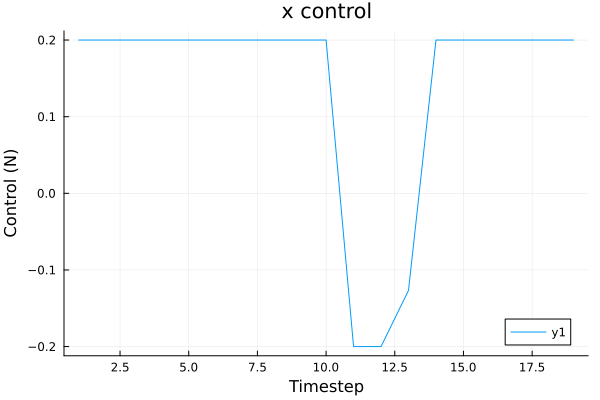

In [71]:
plot(u_traj_pop[1,:]*acceleration_scale*1e3, title="x control", ylabel="Control (N)", xlabel="Timestep") 

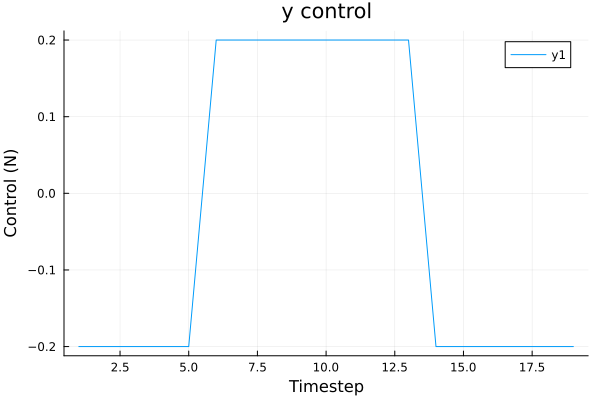

In [72]:
plot(u_traj_pop[2,:]*acceleration_scale*1e3, title="y control", ylabel="Control (N)", xlabel="Timestep") 

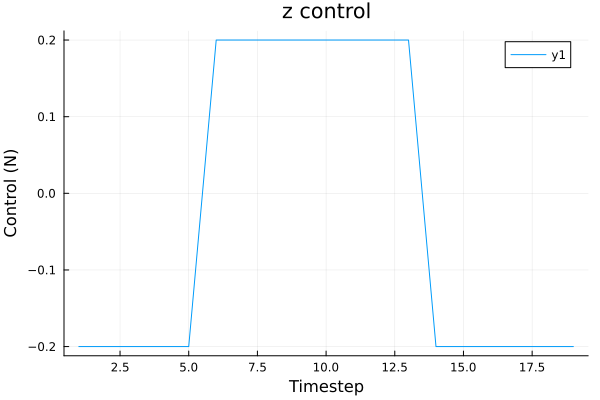

In [73]:
plot(u_traj_pop[3,:]*acceleration_scale*1e3, title="z control", ylabel="Control (N)", xlabel="Timestep") 

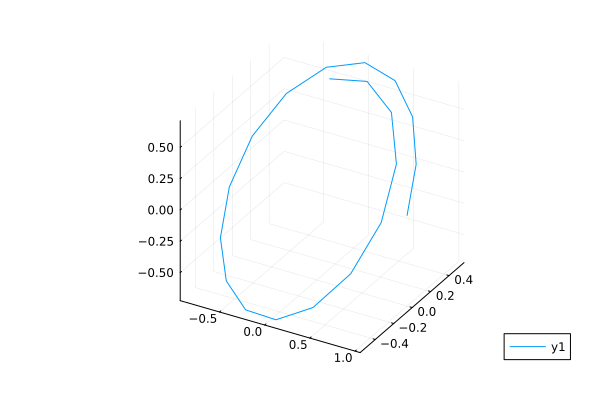

In [74]:
plot(x_traj_pop[1,:], x_traj_pop[2,:], x_traj_pop[3,:])

#plot!(xtraj[1,:]/position_scale, xtraj[2,:]/position_scale, xtraj[3,:]/position_scale)

In [75]:
difference = x_traj_pop - xtraj[1:3, :]/position_scale 

3×20 Matrix{Float64}:
 0.0   0.00253053   0.00767948   0.0138837  …  -0.146756  -0.708936  -1.22708
 0.0  -0.00253053  -0.00717541  -0.0135146      0.977788   0.928272   0.72005
 0.0  -0.00253053  -0.00715107  -0.0135227      1.23918    1.18349    0.92467

In [76]:
#r constraint not being satisfied...

In [77]:
#check the initial condition. constraint not satisfied...
x_traj_pop[:,1] - x_initial_scaled[1:3]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [78]:
v_traj_pop[:,1] - x_initial_scaled[4:6]

3-element Vector{Float64}:
 -4.85328154646478e-38
  0.0
  0.0

In [79]:
#check the constraints: 

position_constraint = zeros(3,N-1)

velocity_constraint = zeros(3,N-1)

acceleration_constraint = zeros(3,N)

r_constraint = zeros(N)

20-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [80]:
x_traj_pop 

3×20 Matrix{Float64}:
 1.0  0.893172  0.675373  0.36191   …  0.45129   0.0919076  -0.288671
 0.0  0.203297  0.378228  0.495638     0.368046  0.455932    0.423584
 0.0  0.25623   0.477368  0.62657      0.472631  0.589676    0.55196

In [81]:
for i=1:N-1

    
    velocity_constraint[:,i] = v_traj_pop[:,i+1] - (v_traj_pop[:,i] + h_scaled*(a_traj_pop[:,i] + u_traj_pop[:,i]))

    position_constraint[:,i] = x_traj_pop[:,i+1] - (x_traj_pop[:,i] + h_scaled*v_traj_pop[:,i+1])
    

end

In [82]:
for i=1:N

    acceleration_constraint[:,i] = a_traj_pop[:,i]*r_traj_pop[i]^3 + μ_scaled*x_traj_pop[:,i]

    r_constraint[i] = r_traj_pop[i]^2 - x_traj_pop[:,i]'*x_traj_pop[:,i]

end

In [83]:
position_constraint  

3×19 Matrix{Float64}:
 0.0  0.0          -5.55112e-17  2.77556e-17  …  1.38778e-17   0.0
 0.0  0.0           0.0          0.0             0.0          -5.55112e-17
 0.0  5.55112e-17   0.0          0.0             0.0           0.0

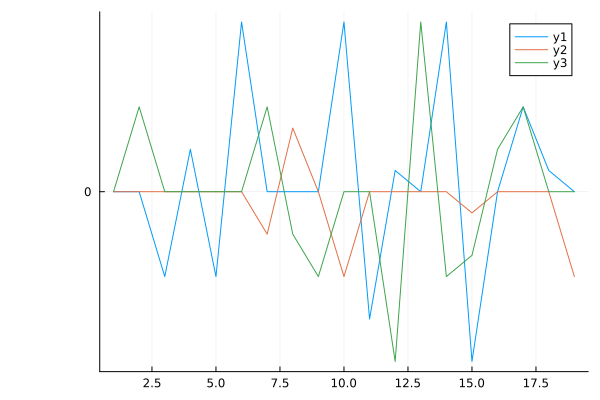

┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [84]:
plot(position_constraint')

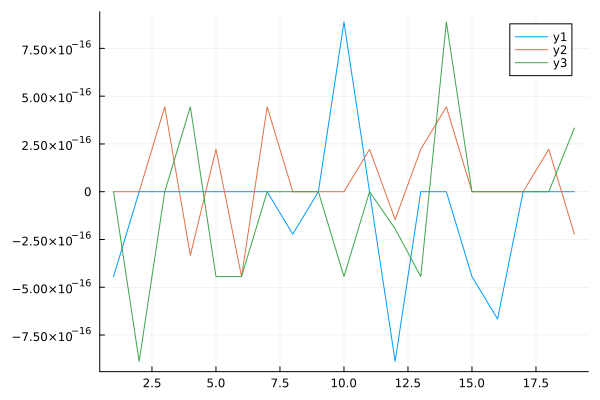

In [85]:
plot(velocity_constraint')

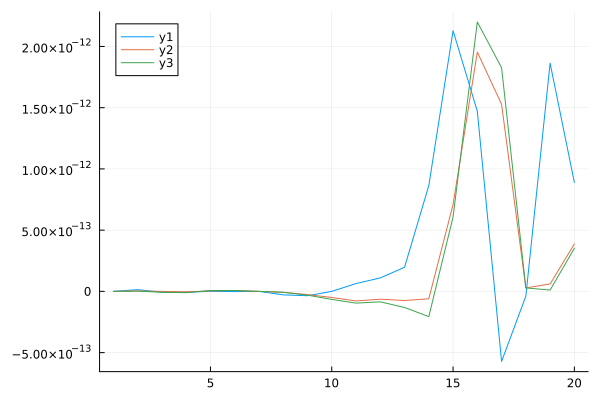

In [86]:
plot(acceleration_constraint')

In [87]:
#satisfies the constraints for 0.25 revs...

In [88]:
#sensitive for the number of knot points. works for 20 knot points 1 rev with higher thrust limit but not for 30...
#maybe numerics, because timestep is the only thing that changes when knot point number changes